In [2]:
# import packages 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from sklearn.preprocessing import OneHotEncoder,StandardScaler
import seaborn as sns
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import keras
from keras import layers

In [6]:
df = pd.read_csv('customer_segmentation.csv',sep='\t')

In [7]:
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [8]:
df.columns

Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response'],
      dtype='object')

# Data Cleaning and Preprocessing

In [9]:
# data cleaning and preprocessing
# Check missing values
print(df.isnull().sum())
# There are small amount of missing values among feature income, we will just simply drop them
df=df.dropna()

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64


In [10]:
# get a new feature Age from year-birth
df['Age']=2022-df['Year_Birth']

In [11]:
print(df['Education'].value_counts())
# as I searched, 2n Cycle is equal to Master degree. Thus we convert 2n Cycle as Master
df['Education']=df['Education'].replace({'2n Cycle':'Master','Basic':'Graduation'})
# And Education feature is ordinal, we can represent them as numbers
df['Education']=df['Education'].replace({'Graduation':1,'Master':2,'PhD':3})
print(df['Education'].value_counts())

Graduation    1116
PhD            481
Master         365
2n Cycle       200
Basic           54
Name: Education, dtype: int64
1    1170
2     565
3     481
Name: Education, dtype: int64


In [12]:
print(df['Marital_Status'].value_counts())
df['Marital_Status']=df['Marital_Status'].replace({'Divorced':0,'Widow':0,
                                                   'Alone':0,'YOLO':0,'Absurd':0,'Single':0,'Married':1,'Together':1})
print(df['Marital_Status'].value_counts())
#encoder=OneHotEncoder()
#transformed=encoder.fit_transform(df[['Marital_Status']]).toarray()
#df[encoder.categories_[0]]=transformed

Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: Marital_Status, dtype: int64
1    1430
0     786
Name: Marital_Status, dtype: int64


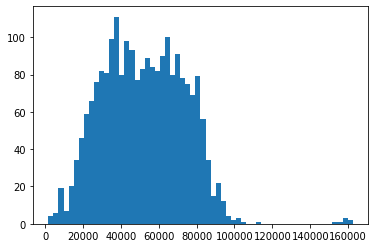

In [13]:
# there is an outlier where income is 666666, drop it
df=df[df['Income']<300000]
plt.hist(df['Income'],bins=60)
plt.show()

In [14]:
# Combine Kidhome and Teenhome as ChildNum
# There is no outliers among Kidhome and Teenhome
print(df['Kidhome'].value_counts())
print(df['Teenhome'].value_counts())
df['ChildNum']=df['Kidhome']+df['Teenhome']

0    1283
1     886
2      46
Name: Kidhome, dtype: int64
0    1146
1    1018
2      51
Name: Teenhome, dtype: int64


In [15]:
# create a new feature Customer_days to calculate number of days the customer became a member
days=[]
df['Dt_Customer']=pd.to_datetime(df["Dt_Customer"],dayfirst=True)
day2=datetime.datetime(2022,4,15)
for i in df['Dt_Customer']:
    days.append(day2-i)
df['Customer_days']=days
df['Customer_days']=df["Customer_days"].dt.days

In [16]:
df=df.drop(['ID','Year_Birth','Kidhome','Teenhome','Dt_Customer','Complain'
            ,'Z_CostContact','Z_Revenue','AcceptedCmp1','AcceptedCmp2','AcceptedCmp3','AcceptedCmp4','AcceptedCmp5','Response'],axis=1)

In [17]:
df.describe()

,Education,Marital_Status,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Age,ChildNum,Customer_days
count,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000
mean,1.689391,0.645147,51969.861400,49.024379,305.225282,26.361625,167.063205,37.651016,27.040632,43.979684,2.322799,4.085779,2.671783,5.802257,5.318736,53.183296,0.947178,3200.503837
std,0.805441,0.478577,21526.320095,28.949608,337.345380,39.802036,224.311559,54.760822,41.077594,51.822660,1.923820,2.741473,2.927179,3.250974,2.425863,11.987000,0.749230,202.478727
min,1.000000,0.000000,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,26.000000,0.000000,2847.000000
25%,1.000000,0.000000,35284.000000,24.000000,24.000000,2.000000,16.000000,3.000000,1.000000,9.000000,1.000000,2.000000,0.000000,3.000000,3.000000,45.000000,0.000000,3027.000000
50%,1.000000,1.000000,51373.000000,49.000000,175.000000,8.000000,68.000000,12.000000,8.000000,25.000000,2.000000,4.000000,2.000000,5.000000,6.000000,52.000000,1.000000,3202.000000
75%,2.000000,1.000000,68487.000000,74.000000,505.000000,33.000000,232.500000,50.000000,33.000000,56.000000,3.000000,6.000000,4.000000,8.000000,7.000000,63.000000,1.000000,3376.000000
max,3.000000,1.000000,162397.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,262.000000,321.000000,15.000000,27.000000,28.000000,13.000000,20.000000,129.000000,3.000000,3546.000000


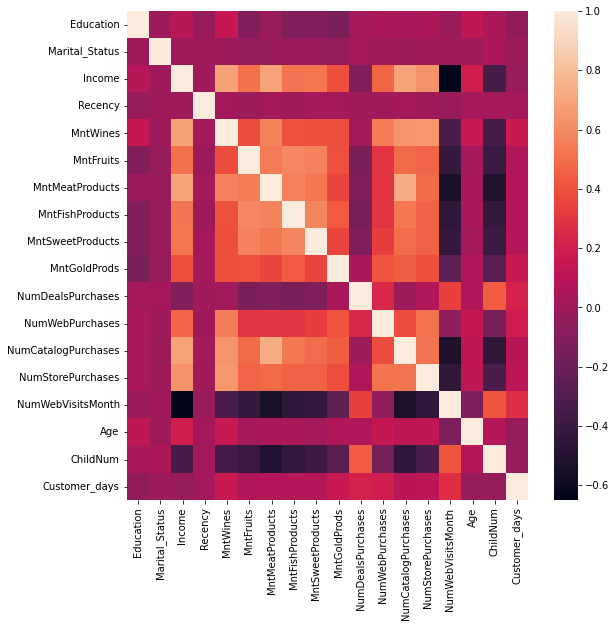

In [18]:
plt.figure(figsize=(9,9))
sns.heatmap(df.corr())

In [21]:
# data preprocessing
dc=df.copy()
standard_scaler=StandardScaler()
dc=pd.DataFrame(standard_scaler.fit_transform(dc),columns=df.columns)

In [48]:
dc.shape

(2215, 18)

# Dimensionality Reduction

[0.34219582 0.44791398 0.52587727 0.58250723 0.63838967 0.69221885
 0.73758106 0.77757018 0.81526431 0.84952784 0.87696663 0.90115586
 0.92472447 0.94647112 0.96459787 0.97824186 0.99088254 1.        ]


Text(0, 0.5, 'Cumulative Proportion of Variance')

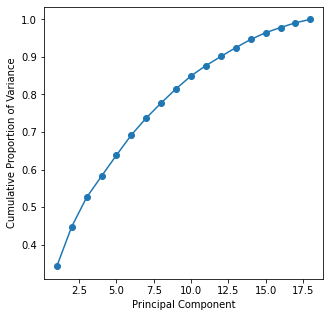

In [23]:
pca=PCA().fit(dc)
plt.figure(figsize=(5,5))
x_components=np.arange(1,19,step=1)
y_cumu_var=np.cumsum(pca.explained_variance_ratio_)
z_var_ratio=pca.explained_variance_ratio_
var_comp=pca.explained_variance_
print(y_cumu_var)
plt.plot(x_components,y_cumu_var,marker='o')
plt.xlabel('Principal Component')
plt.ylabel('Cumulative Proportion of Variance')

Text(0, 0.5, 'Proportion of Variance')

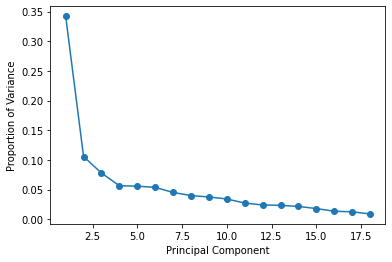

In [24]:
plt.plot(x_components,z_var_ratio,marker='o')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance')

Text(0, 0.5, 'Variance')

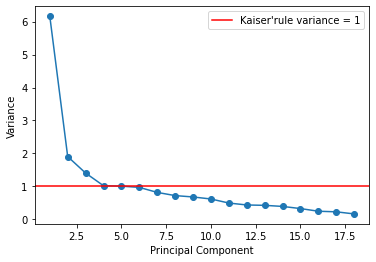

In [25]:
plt.plot(x_components,var_comp,marker='o')
plt.axhline(y=1,color='red',label='Kaiser\'rule variance = 1')
plt.legend()
plt.xlabel('Principal Component')
plt.ylabel('Variance')

In [52]:
# find the number of components that is greater than 1
[p for p in var_comp if p >1]

[6.162306784851124,
 1.9037863597750435,
 1.403973150559795,
 1.0197996637577917,
 1.0063383017257992]

In [53]:
# find the most important features
pca=PCA(n_components=5)
pca.fit(dc)
print(pca.components_)

[[-0.00259677 -0.00927448  0.34146587  0.00633206  0.30187915  0.28691345
   0.3293324   0.29701946  0.28665118  0.23240715 -0.05636668  0.2176632
   0.33035646  0.29790809 -0.26238872  0.05494838 -0.23467549  0.03970704]
 [ 0.09388427  0.029671    0.01102788  0.01396249  0.21491957 -0.08112446
  -0.07512529 -0.08775383 -0.06496433  0.16031894  0.55923249  0.41478488
   0.03819504  0.17430592  0.34204209  0.16555604  0.30012953  0.37794433]
 [-0.55951589 -0.06097486 -0.23399057  0.02613173 -0.16647146  0.19611265
   0.01564174  0.1937527   0.18079306  0.22158341  0.0360748  -0.01771777
  -0.06488075 -0.09129493  0.23935007 -0.45445369 -0.14013427  0.38004307]
 [-0.32609465  0.41680352  0.03976251  0.71742234 -0.11869763  0.0354134
  -0.02967733  0.05160035  0.07301501  0.07887781  0.11069292 -0.04929476
  -0.00253216 -0.01148923 -0.13570193  0.23059498  0.23003055 -0.18411227]
 [ 0.09053111 -0.80587939 -0.01375842  0.5486211   0.03707791 -0.04281508
   0.0244084  -0.03684952 -0.0278571

From the above eigenvectors , we can see the top 3 important features
    important feature1    important feature2    important feature3
pc1: income            NumCatalogPurchase     MntMeatProducts 
    0.34146583         0.33035639           0.3293325
pc2: NumDealsPurchases    NumWebPurchases       Customer_days
    0.55912618         0.41462808           0.37788749
pc3: Education          Age               Customer_days
    -0.559422          -0.45443661          0.38013223
pc4: Recency           Marital_Status        Education
    0.71930882         0.4137333            -0.32533483
pc5: Marital_Status      Recency             Customer_days
    -0.80706347        0.54623938           0.11342487

[0.34219582 0.10571816 0.07796322 0.0566296  0.05587906]
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


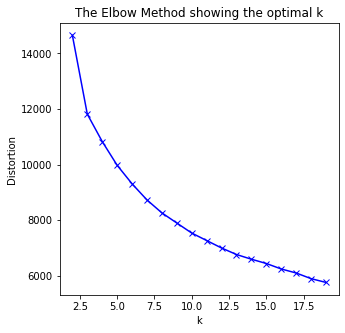

In [44]:
def pca_cal(num,data):
    pca=PCA(n_components=num)
    pca.fit(data)
    print(pca.explained_variance_ratio_)
    dc_pca=pd.DataFrame(pca.transform(data))
    distortions=kmeans_cal(dc_pca)
    return distortions
def kmeans_cal(matrix): 
    distortions=[]
    K=range(2,20)
    sil_score=[]
    db_score=[]
    for k in K:
        print(k)
        kmeanModel=KMeans(n_clusters=k)
        kmeanModel.fit(matrix)
        distortions.append(kmeanModel.inertia_)
        pred_df=pd.DataFrame(matrix)
        sil_score.append(silhouette_score(X=pred_df,labels=kmeanModel.labels_))
        db_score.append(davies_bouldin_score(X=pred_df,labels=kmeanModel.labels_))
    return distortions,sil_score,db_score
K=range(2,20)
distortions,_,_=pca_cal(5,dc)
plt.figure(figsize=(5,5))
plt.plot(K,distortions,'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


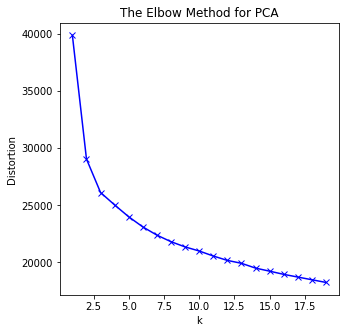

In [33]:
# The original dataset in K-means
distortions=kmeans_cal(dc)
plt.figure(figsize=(5,5))
plt.plot(K,distortions,'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method for PCA')
plt.show()

In [34]:
# This part of code is inspired by keras documentation about autoencoder
# This is the size of our encoded representations
def construct_autoencoder(num,input):
  encoding_dim = num  
  input_img = keras.Input(shape=(18,))
  encoded = layers.Dense(10, activation='relu')(input_img)
  encoded = layers.Dense(num, activation='relu')(encoded)
  encoder = keras.Model(input_img, encoded)
  decoded = layers.Dense(10, activation='relu')(encoded)
  decoded = layers.Dense(18, activation='sigmoid')(decoded)

# This model maps an input to its reconstruction
  autoencoder = keras.Model(input_img, decoded)
# This model maps an input to its encoded representation
  autoencoder.compile(optimizer='Adam', loss='mean_squared_error')
  autoencoder.fit(input, input,
                epochs=500,
                batch_size=256,
                shuffle=True)
  pred_matrix=encoder.predict(input)
  return pred_matrix
pred_matrix=construct_autoencoder(5,dc)

Epoch 1/500
9/9 [==============================] - 1s 4ms/step - loss: 1.2428
Epoch 2/500
9/9 [==============================] - 0s 4ms/step - loss: 1.2353
Epoch 3/500
9/9 [==============================] - 0s 4ms/step - loss: 1.2266
Epoch 4/500
9/9 [==============================] - 0s 4ms/step - loss: 1.2159
Epoch 5/500
9/9 [==============================] - 0s 7ms/step - loss: 1.2018
Epoch 6/500
9/9 [==============================] - 0s 4ms/step - loss: 1.1833
Epoch 7/500
9/9 [==============================] - 0s 4ms/step - loss: 1.1597
Epoch 8/500
9/9 [==============================] - 0s 4ms/step - loss: 1.1309
Epoch 9/500
9/9 [==============================] - 0s 4ms/step - loss: 1.0981
Epoch 10/500
9/9 [==============================] - 0s 4ms/step - loss: 1.0631
Epoch 11/500
9/9 [==============================] - 0s 4ms/step - loss: 1.0283
Epoch 12/500
9/9 [==============================] - 0s 4ms/step - loss: 0.9960
Epoch 13/500
9/9 [==============================] - 0s 4ms/st

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


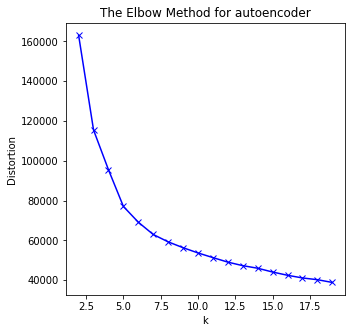

In [39]:
# Evaluate Models
distortion,sil_score,db_score=kmeans_cal(pred_matrix)
K=range(2,20)
plt.figure(figsize=(5,5))
plt.plot(K,distortion,'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method for autoencoder')
plt.show()

In [40]:
distortions2,sil_score2,db_score2=pca_cal(5,dc)

[0.34219582 0.10571816 0.07796329 0.05662898 0.05587873]
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


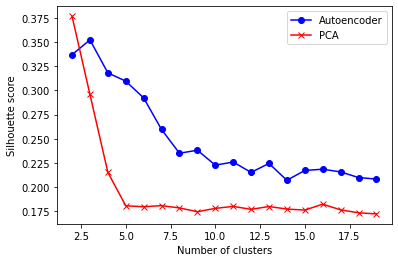

In [45]:
K=range(2,20)
plt.plot(K,sil_score,color='blue',marker='o',label='Autoencoder')
plt.plot(K,sil_score2,color='red',marker='x',label='PCA')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.legend()

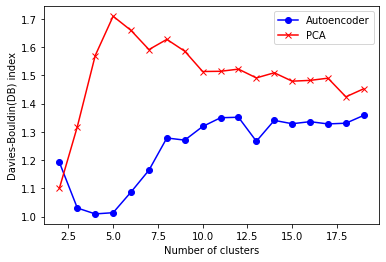

In [43]:
K=range(2,20)
plt.plot(K,db_score,color='blue',marker='o',label='Autoencoder')
plt.plot(K,db_score2,color='red',marker='x',label='PCA')
plt.xlabel('Number of clusters')
plt.ylabel('Davies-Bouldin(DB) index')
plt.legend()

In [51]:
# Evaluate Models
# silhouette_score
kmeanModel=KMeans(n_clusters=4)
kmeanModel.fit(pred_matrix)
pred_df=pd.DataFrame(pred_matrix)
pred_df['label']=kmeanModel.labels_

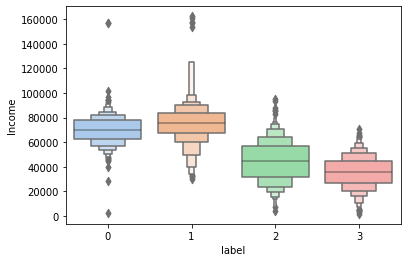

In [57]:
df['label']=kmeanModel.labels_
sns.boxenplot(data = df,x=df["label"], y=df["Income"], palette= 'pastel')

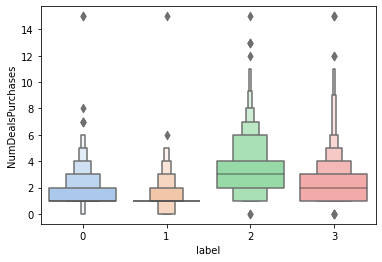

In [56]:
sns.boxenplot(data = df,x=df["label"], y=df["NumDealsPurchases"], palette= 'pastel')

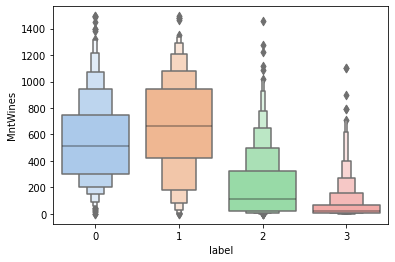

In [71]:
sns.boxenplot(data = df,x=df["label"], y=df["MntWines"], palette= 'pastel')

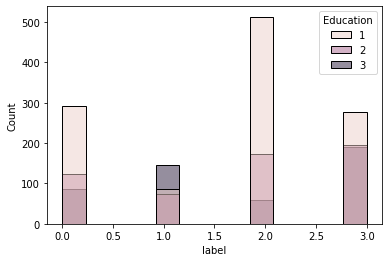

In [70]:
sns.histplot(data = df,x=df["label"], hue=df["Education"])

In [62]:
df.describe()

,Education,Marital_Status,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Age,ChildNum,Customer_days,label
count,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000,2215.000000
mean,1.689391,0.645147,51969.861400,49.024379,305.225282,26.361625,167.063205,37.651016,27.040632,43.979684,2.322799,4.085779,2.671783,5.802257,5.318736,53.183296,0.947178,3200.503837,1.709707
std,0.805441,0.478577,21526.320095,28.949608,337.345380,39.802036,224.311559,54.760822,41.077594,51.822660,1.923820,2.741473,2.927179,3.250974,2.425863,11.987000,0.749230,202.478727,1.122236
min,1.000000,0.000000,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,26.000000,0.000000,2847.000000,0.000000
25%,1.000000,0.000000,35284.000000,24.000000,24.000000,2.000000,16.000000,3.000000,1.000000,9.000000,1.000000,2.000000,0.000000,3.000000,3.000000,45.000000,0.000000,3027.000000,1.000000
50%,1.000000,1.000000,51373.000000,49.000000,175.000000,8.000000,68.000000,12.000000,8.000000,25.000000,2.000000,4.000000,2.000000,5.000000,6.000000,52.000000,1.000000,3202.000000,2.000000
75%,2.000000,1.000000,68487.000000,74.000000,505.000000,33.000000,232.500000,50.000000,33.000000,56.000000,3.000000,6.000000,4.000000,8.000000,7.000000,63.000000,1.000000,3376.000000,3.000000
max,3.000000,1.000000,162397.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,262.000000,321.000000,15.000000,27.000000,28.000000,13.000000,20.000000,129.000000,3.000000,3546.000000,3.000000


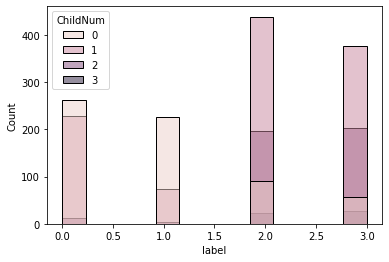

In [77]:
sns.histplot(data = df,x=df["label"], hue=df["ChildNum"])

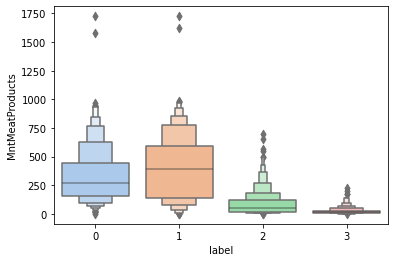

In [79]:
sns.boxenplot(data = df,x=df["label"], y=df["MntMeatProducts"], palette= 'pastel')

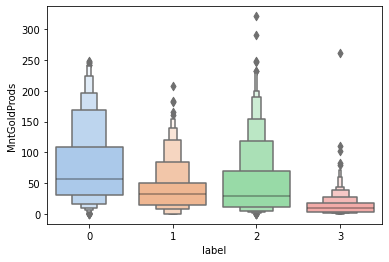

In [83]:
sns.boxenplot(data = df,x=df["label"], y=df["MntGoldProds"], palette= 'pastel')